Natural Disasters and Weather
------------
Natural disasters are becoming more frequent due to climate change. Understanding how weather patterns correlate to the different disasters may provide insight for better prediction and preparedness. By combining historical disasters data with weather information, the project aims to help discover patterns that may be useful for future forecasting.

The objective of this project is to determine if temperature data has a measurable correlation to the occurrence of natural disasters.

--------
Data from https://public.emdat.be/data
*   Classification: Natural
*   Countries: Africa, Americas, Asia, Europe, Oceania
*   Time period: 2000 to 2025
--------------
Get API key from https://www.worldweatheronline.com/weather-api/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from google.colab import userdata
import time
import datetime

api_key = userdata.get('worldweatherAPIkey')
!curl -L "https://raw.githubusercontent.com/Cynthia-Chin/CIS2300-final-project/main/emdat_disasters.xlsx" -o emdat_disasters.xlsx

excel_file = "emdat_disasters.xlsx"
disasters = pd.read_excel(excel_file)

csv_file = "emdat_disasters.csv"
disasters.to_csv(csv_file, index=False)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3114k  100 3114k    0     0  2903k      0  0:00:01  0:00:01 --:--:-- 2905k


In [2]:
disasters = disasters.dropna(subset=['Start Year', 'Start Month', 'Start Day'])

df_selected = disasters[['Start Year', 'Start Month', 'Start Day', 'Country', 'Disaster Type']].copy()

df_selected.loc[:, 'Start Year'] = df_selected['Start Year'].astype(int)
df_selected.loc[:, 'Start Month'] = df_selected['Start Month'].astype(int)
df_selected.loc[:, 'Start Day'] = df_selected['Start Day'].astype(int)

df_selected.loc[:, 'start_date'] = pd.to_datetime({
    'year': df_selected['Start Year'],
    'month': df_selected['Start Month'],
    'day': df_selected['Start Day']
})

df_selected = df_selected[['start_date', 'Country', 'Disaster Type']]

# Display the top and last 50 rows
print(df_selected.head(50))
print(df_selected.tail(50))

   start_date                           Country        Disaster Type
3  2000-01-08                            Angola                Flood
5  2000-01-16                         Guatemala    Volcanic activity
6  2000-01-18        Iran (Islamic Republic of)                Storm
7  2000-01-26                        Mozambique                Flood
8  2000-01-15                      South Africa             Wildfire
9  2000-01-01                            Brazil                Flood
11 2000-01-02          United States of America                Storm
12 2000-01-02                        Bangladesh           Earthquake
15 2000-01-14                             China           Earthquake
16 2000-01-26                             China           Earthquake
17 2000-01-30                           Réunion                Storm
18 2000-01-28                       Philippines                Flood
19 2000-01-11                             China           Earthquake
20 2000-01-26                     

In [3]:
def get_weather_data(location, date):
    # URL for the API endpoint (for historical weather)
    url = f"https://api.worldweatheronline.com/premium/v1/past-weather.ashx"

    # Parameters for the API request
    params = {
        "key": api_key,
        "q": location,           # Location entered by the user
        "date": date,            # Date entered by the user
        "format": "json",        # We want the response in JSON format
        "tp": "24",              # Time period for the weather data (1-hour intervals)
    }
    response = requests.get(url, params=params)
    data  = response.json()
    try:
        temp_celsius = data['data']['weather'][0]['hourly'][0]['tempC']
        temp_celsius = float(temp_celsius)  # Ensure it's numeric
        temp_fahrenheit = (temp_celsius * 9/5) + 32
        return round(temp_fahrenheit, 2)
    except (KeyError, IndexError, TypeError, ValueError):
        return None  # Handle errors

def search_disasters_by_country(df, country):
    # Filter disasters for the specified country
    df_filtered = df[df['Country'].str.contains(country, case=False, na=False)]
    df_filtered = df_filtered.sort_values(by='start_date', ascending=False).head(5)

    # Get weather for each disaster
    temperatures = []
    for _, row in df_filtered.iterrows():
        location = row['Country']
        date_str = row['start_date'].strftime('%Y-%m-%d')
        temp = get_weather_data(location, date_str)
        temperatures.append(temp)

    # Add temperature column to the result
    df_filtered = df_filtered.copy()
    df_filtered['Temperature (F)'] = temperatures
    return df_filtered[['start_date', 'Country', 'Disaster Type', 'Temperature (F)']]

def search_disasters_by_keyword(df, keyword):
    # Filter by disaster keyword
    df_filtered = df[df['Disaster Type'].str.contains(keyword, case=False, na=False)]
    df_filtered = df_filtered.sort_values(by='start_date', ascending=False).head(20)

    # Get temperatures
    temperatures = []
    for _, row in df_filtered.iterrows():
        location = row['Country']
        date_str = row['start_date'].strftime('%Y-%m-%d')
        temp = get_weather_data(location, date_str)
        temperatures.append(temp)

    # Add temperatures to DataFrame
    df_filtered = df_filtered.copy()
    df_filtered['Temperature (F)'] = temperatures



    return df_filtered

In [4]:
while True:
    print("\nChoose an option:")
    print("1: Search for disasters by country and get weather")
    print("2: Search for disasters by keyword, get weather, and plot")
    print("3: Exit")

    choice = input("Enter your choice (1, 2, or 3): ")

    if choice == '1':
        country = input("Enter a country: ")
        result = search_disasters_by_country(df_selected, country)
        print(result[['start_date', 'Country', 'Disaster Type', 'Temperature (F)']])

    elif choice == '2':
        keyword = input("Enter a disaster keyword (e.g., flood, earthquake): ")
        result = search_disasters_by_keyword(df_selected, keyword)
        print(result[['start_date', 'Country', 'Disaster Type', 'Temperature (F)']])

        # Plotting the result
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='start_date', y='Temperature (F)', data=result, hue='Disaster Type', palette='deep', legend=False)
        plt.title(f"Temperature on Days of '{keyword}' Disasters")
        plt.xlabel("Date")
        plt.ylabel("Temperature (F)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    elif choice == '3':
        print("Exiting program.")
        break
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")


Choose an option:
1: Search for disasters by country and get weather
2: Search for disasters by keyword, get weather, and plot
3: Exit
Enter your choice (1, 2, or 3): 1
Enter a country: Myanmar
      start_date  Country        Disaster Type  Temperature (F)
10288 2025-03-28  Myanmar           Earthquake             98.6
10093 2024-09-08  Myanmar                Storm             80.6
10022 2024-06-30  Myanmar                Flood             87.8
9954  2024-04-01  Myanmar  Extreme temperature            104.0
9701  2023-10-05  Myanmar                Flood             89.6

Choose an option:
1: Search for disasters by country and get weather
2: Search for disasters by keyword, get weather, and plot
3: Exit
Enter your choice (1, 2, or 3): 3
Exiting program.


***search_disasters_by_keyword*** function examples:


Enter a disaster keyword (e.g., flood, earthquake): earthquake
      start_date                     Country Disaster Type  Temperature (F)
10297 2025-04-13                  Tajikistan    Earthquake             75.2
10289 2025-03-28                    Thailand    Earthquake            100.4
10288 2025-03-28                     Myanmar    Earthquake             98.6
10287 2025-03-28                       China    Earthquake             50.0
10236 2025-01-07                       Nepal    Earthquake             62.6
10235 2025-01-07                       China    Earthquake             41.0
10241 2025-01-04                    Ethiopia    Earthquake             69.8
10210 2024-12-17                     Vanuatu    Earthquake             86.0
10170 2024-11-10                        Cuba    Earthquake             82.4
10132 2024-10-16                     Türkiye    Earthquake              NaN
10111 2024-09-18                   Indonesia    Earthquake             93.2
10065 2024-08-02         

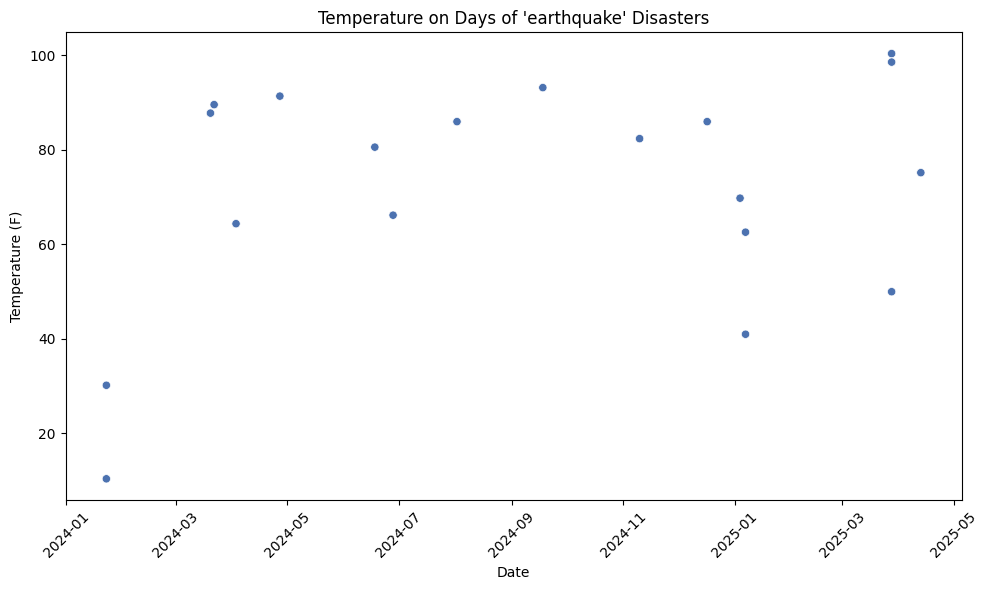

In [ ]:
#search_disasters_by_keyword
keyword = input("Enter a disaster keyword (e.g., flood, earthquake): ")
result = search_disasters_by_keyword(df_selected, keyword)
print(result[['start_date', 'Country', 'Disaster Type', 'Temperature (F)']])

# Plotting the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='start_date', y='Temperature (F)', data=result, hue='Disaster Type', palette='deep', legend=False)
plt.title(f"Temperature on Days of '{keyword}' Disasters")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Enter a disaster keyword (e.g., flood, earthquake): Wildfire
      start_date                   Country Disaster Type  Temperature (F)
10285 2025-03-23                     Japan      Wildfire             71.6
10284 2025-03-21         Republic of Korea      Wildfire             51.8
10265 2025-02-27                     Japan      Wildfire             57.2
10248 2025-01-27                     Chile      Wildfire             80.6
10244 2025-01-27                 Australia      Wildfire             91.4
10242 2025-01-15                 Argentina      Wildfire             98.6
10237 2025-01-06  United States of America      Wildfire             30.2
10200 2024-12-09  United States of America      Wildfire             51.8
10190 2024-11-23      Syrian Arab Republic      Wildfire             53.6
10162 2024-11-06  United States of America      Wildfire             75.2
10099 2024-09-15                  Portugal      Wildfire             89.6
10103 2024-09-04  United States of America      Wil

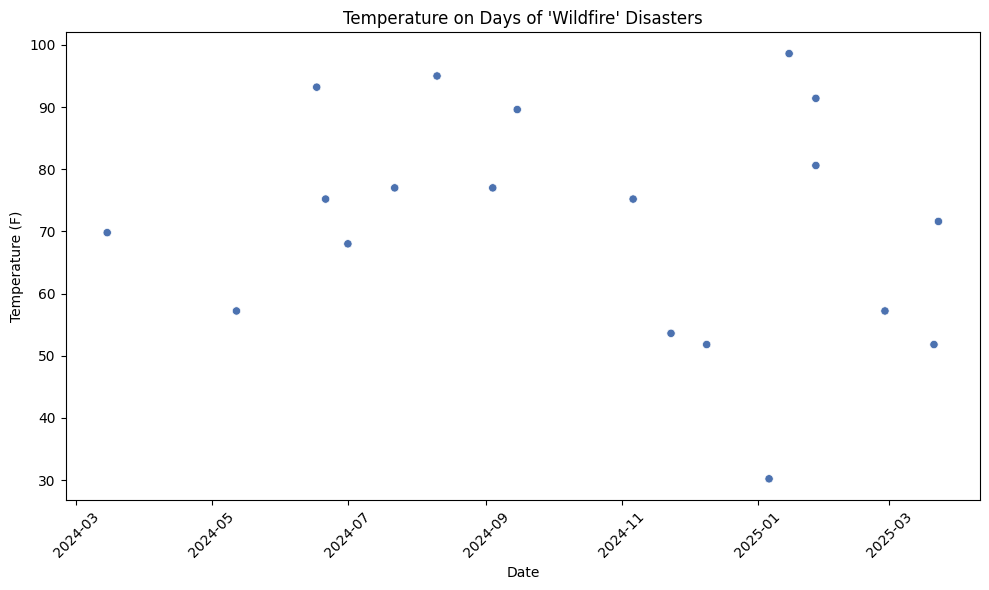

In [ ]:
#search_disasters_by_keyword
keyword = input("Enter a disaster keyword (e.g., flood, earthquake): ")
result = search_disasters_by_keyword(df_selected, keyword)
print(result[['start_date', 'Country', 'Disaster Type', 'Temperature (F)']])

# Plotting the result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='start_date', y='Temperature (F)', data=result, hue='Disaster Type', palette='deep', legend=False)
plt.title(f"Temperature on Days of '{keyword}' Disasters")
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()